# Расчёт дескрипторов флуоресценции

Загружаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

Создаём датафремы для хранения расчитанных дескрипторов и словари для хранения спектров

In [2]:
descr280 = pd.DataFrame(data=[],columns=['name','I280','λ280', 'A4_A1', 'I465'])
descr350 = pd.DataFrame(data=[],columns=['name','I350','λ350', 'Asm350', 'I518'])
specs280 = {}
specs350 = {}

Функция для расчётов дескрипторов на основе спектров, полученных при длине возбуждения 280 нм

In [3]:
def find_descr_280 (name, df):
    I280 = df.query('SIGNAL2 > 320 and SIGNAL2 < 550')['C'].sum() #интеграл пика
    
    max_peak = data.query('SIGNAL2 > 350 and SIGNAL2 < 500')['C'].max() #находим максимум пика
    wave_max = data.query('C == @max_peak')['SIGNAL2'].to_list()[0] #находим длину волны максимума
    
    #дескриптор Золна
    A4_A1 = df.query('SIGNAL2 > 435 and SIGNAL2 < 480')['C'].sum() / df.query('SIGNAL2 > 320 and SIGNAL2 < 365')['C'].sum()
    
    #дескриптор Калбитца
    I465 = df.query('SIGNAL2 > 460 and SIGNAL2 < 470')['C'].sum() / df.query('SIGNAL2 > 395 and SIGNAL2 < 405')['C'].sum()
    
    return [name[:-10], I280, wave_max, A4_A1, I465]

Функция для расчётов дескрипторов на основе спектров, полученных при длине возбуждения 280 нм

In [4]:
def find_descr_350 (name, df):
    I350 = df.query('SIGNAL2 > 410 and SIGNAL2 < 600')['C'].sum() #интеграл пика
    
    max_peak = data.query('SIGNAL2 > 410 and SIGNAL2 < 500')['C'].max() #находим максимум пика
    wave_max = data.query('C == @max_peak')['SIGNAL2'].to_list()[0] #находим длину волны максимума 
    
    #ассимитричность
    asm = df.query('SIGNAL2 > 419 and SIGNAL2 < 461')['C'].sum() / df.query('SIGNAL2 > 549 and SIGNAL2 < 601')['C'].sum()
    
    #дескриптор Милори
    I518 = df.query('SIGNAL2 > 515 and SIGNAL2 < 521')['C'].sum()
    
    return [name[:-10], I350, wave_max, asm, I518]

цикл считывания спектров и расчёт дескрипторов

In [5]:
a = b = 0 #счётчик

for name in os.listdir(path=str(Path().resolve()) + '/data'):
    wave = int(name[-9:-6]) #файлы подаются в формате name_XXXnm.csv, где XXX - длина возбуждения, вырезаем это значение
    data = pd.read_csv(f'data/{name}') 
    data = data.drop(columns=['B']) #ненужный столбец удаляем
    
    #спектры довольно шумные, чтобы их сгладить, усредним спектр по целым длинам волн
    for i in range(0, data.shape[0]-1, 5):
        data.at[i, 'C'] = (data.at[i, 'C'] + data.at[i+1, 'C'] + data.at[i+2, 'C'] + data.at[i+3, 'C'] + data.at[i+4, 'C'])/5
    data = data.loc[::5]
    
    #В зависимости от длины возбуждения вызываюм ту или иную функцию, запалняем таблицу дескрипторов
    if wave == 280:
        descr280.loc[a] = find_descr_280(name, data)
        specs280[name[:-10]] = data
        a += 1
    if wave == 350:
        descr350.loc[b] = find_descr_350(name, data)
        specs350[name[:-10]] = data
        b += 1

Объединяем датафрейм с дескрипторами по колонке с названием образца из файла

In [6]:
data = descr350.merge(descr280, on='name').dropna().reset_index(drop=True)

Загружаем данные органического углерода в образцах, мг/л

In [7]:
c_org = {"exampl_1":0.766,
        "exampl_3":0.947,
        "exampl_2":0.861,
        }

Вставляем их по ключу в датафрейм с данными

In [8]:
for i, row in data.iterrows():
    if row['name'] in c_org:
        data.at[i, 'c_org'] = c_org[row['name']]

Находим нормированные значения интегралов

In [9]:
data['I350'] = data['I350'] / data['c_org']
data['I280'] = data['I280'] / data['c_org']
data['I518'] = data['I518'] / data['c_org']

|	Дескриптор	|	Описание	|
|	:--	|	:--	|
|	I350, л/мг	|	Интеграл пика от 410 нм до 600 нм, нормированный на органический углерод	|
|	λ350	|	Длина волны максимум пика	|
|	Asm350	|	Отношение интегралов (420-460) / (550-600)	|
|	I518, л/мг	|	Интеграл пика от 517 нм до 519 нм, нормированный на органический углерод (что-то похожее на дескриптор Милори)	|
|	I280, л/мг	|	Интеграл пика от 320 нм до 550 нм, нормированный на органический углерод	|
|	λ280	|	Длина волны максимум пика	|
|	A4_A1	|	Отношение интегралов (435-480) / (320-365), что-то похожее на дескриптор Золна	|
|	I465	|	Отношение интегралов (460-470) / (395-405), что-то похожее на дескриптор Калбитца	|

In [10]:
data

,name,I350,λ350,Asm350,I518,I280,λ280,A4_A1,I465,c_org
0,exampl_1,1.07675e+06,445.0,2.229396,29258.5,1.121223e+06,444.0,2.731413,1.343649,0.766
1,exampl_2,1.27801e+06,447.0,5.690164,24756.3,1.160817e+06,433.0,2.441557,1.002819,0.861
2,exampl_3,917714,432.0,3.097728,21396,8.695345e+05,434.0,1.572965,1.188700,0.947


Сохраняем данные в файл

In [11]:
data.to_csv('data.csv', sep=';', index=False)

Построим спектры, возбужденные при 350 нм

Text(0.5, 1.0, '350 nm')

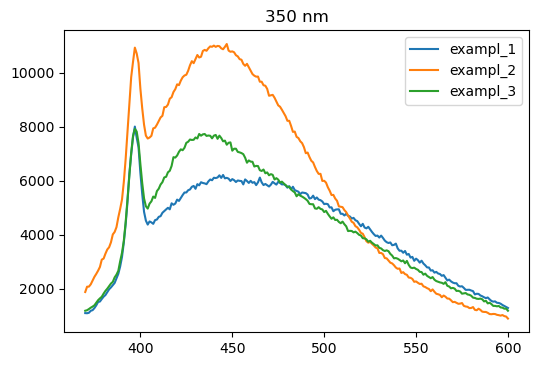

In [12]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)

for spec in specs350:
    ax.plot(specs350[spec]['SIGNAL2'], specs350[spec]['C'], label=spec)
ax.legend()
ax.set_title('350 nm')

Построим спектры, возбужденные при 280 нм

Text(0.5, 1.0, '280 nm')

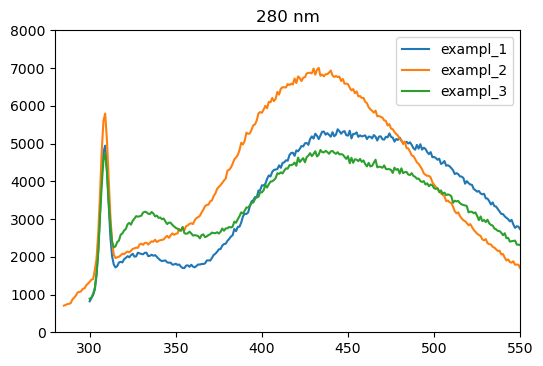

In [13]:
fig, ax = plt.subplots(figsize=(6,4), dpi=100)

for spec in specs280:
    ax.plot(specs280[spec]['SIGNAL2'], specs280[spec]['C'], label=spec)
ax.legend()
ax.set_xlim(280, 550)
ax.set_ylim(0, 8000)
ax.set_title('280 nm')